Total classes in dataset

In [21]:
import pickle 
from collections import Counter
with open('test.pickle', 'rb') as f2:
    data2 = pickle.load(f2)
print(len(data2))
cve_counter1 = Counter(entry['cwe'] for entry in data2 )
print(cve_counter1)
print(len(cve_counter1))

12845
Counter({'79': 2256, '119': 1070, '89': 957, '787': 890, '20': 810, '200': 590, '125': 532, '22': 518, '352': 453, '416': 325, '78': 296, '94': 292, '287': 285, '476': 223, '862': 220, '190': 200, '120': 196, '434': 194, '77': 148, '400': 138, '798': 129, '362': 122, '863': 118, '59': 109, '502': 107, '269': 106, '732': 98, '306': 94, '611': 92, '522': 90, '918': 90, '295': 81, '74': 71, '601': 71, '276': 64, '770': 59, '401': 52, '319': 51, '668': 45, '427': 44, '532': 44, '426': 42, '312': 42, '415': 42, '835': 41, '617': 38, '327': 35, '772': 34, '843': 34, '326': 31, '755': 28, '639': 28, '203': 27, '345': 26, '908': 24, '347': 24, '134': 19})
57


CVE distribution

Total test entries: 12845
Total train entries: 72372
Test dataset CWE counts: Counter({'79': 2256, '119': 1070, '89': 957, '787': 890, '20': 810, '200': 590, '125': 532, '22': 518, '352': 453, '416': 325, '78': 296, '94': 292, '287': 285, '476': 223, '862': 220, '190': 200, '120': 196, '434': 194, '77': 148, '400': 138, '798': 129, '362': 122, '863': 118, '59': 109, '502': 107, '269': 106, '732': 98, '306': 94, '611': 92, '522': 90, '918': 90, '295': 81, '74': 71, '601': 71, '276': 64, '770': 59, '401': 52, '319': 51, '668': 45, '427': 44, '532': 44, '426': 42, '312': 42, '415': 42, '835': 41, '617': 38, '327': 35, '772': 34, '843': 34, '326': 31, '755': 28, '639': 28, '203': 27, '345': 26, '908': 24, '347': 24, '134': 19})
Train dataset CWE counts: Counter({'79': 3030, '89': 3023, '119': 3021, '20': 3014, '787': 3012, '125': 3010, '22': 3005, '200': 2992, '416': 2944, '352': 2819, '78': 2793, '287': 2762, '94': 2731, '476': 2014, '190': 1986, '862': 1831, '434': 1744, '120': 1735, '77

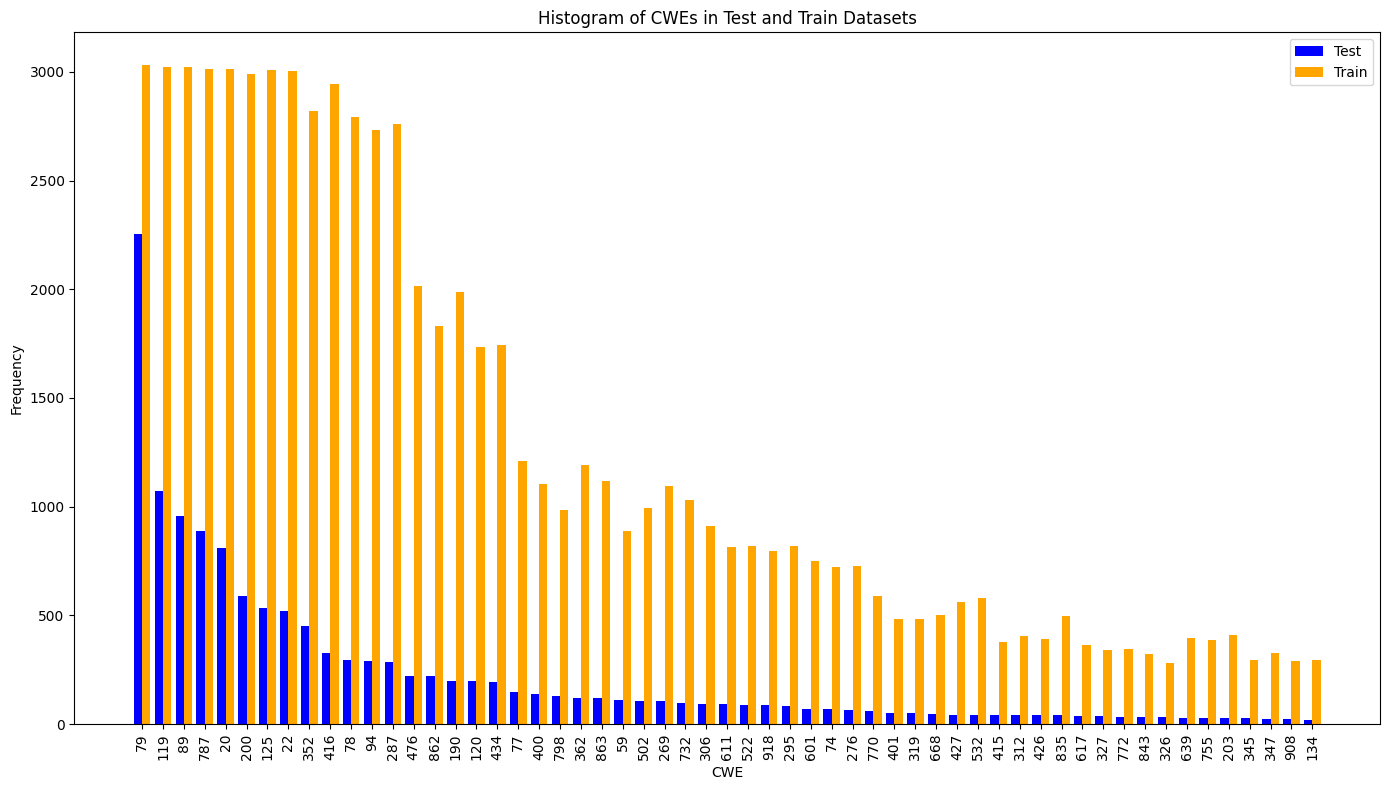

In [7]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Load data from the pickle files
with open('test.pickle', 'rb') as f_test, open('train.pickle', 'rb') as f_train:
    data_test = pickle.load(f_test)
    data_train = pickle.load(f_train)

# Print the total number of entries in each dataset
print(f"Total test entries: {len(data_test)}")
print(f"Total train entries: {len(data_train)}")

# Count occurrences of each CWE in both datasets
cve_counter_test = Counter(entry['cwe'] for entry in data_test)
cve_counter_train = Counter(entry['cwe'] for entry in data_train)

# Print the counters
print("Test dataset CWE counts:", cve_counter_test)
print("Train dataset CWE counts:", cve_counter_train)

# Combine the keys from both counters
all_cwes = set(cve_counter_test.keys()).union(set(cve_counter_train.keys()))

# Create lists of counts for each CWE
test_counts = [cve_counter_test.get(cwe, 0) for cwe in all_cwes]
train_counts = [cve_counter_train.get(cwe, 0) for cwe in all_cwes]

# Sort CWEs by descending order of test_counts
sorted_indices = np.argsort(test_counts)[::-1]
sorted_cwes = [list(all_cwes)[i] for i in sorted_indices]
sorted_test_counts = [test_counts[i] for i in sorted_indices]
sorted_train_counts = [train_counts[i] for i in sorted_indices]

# Plot the histograms
plt.figure(figsize=(14, 8))

bar_width = 0.4
indices = np.arange(len(sorted_cwes))

plt.bar(indices, sorted_test_counts, width=bar_width, color='blue', label='Test')
plt.bar(indices + bar_width, sorted_train_counts, width=bar_width, color='orange', label='Train')

plt.xlabel('CWE')
plt.ylabel('Frequency')
plt.title('Histogram of CWEs in Test and Train Datasets')
plt.xticks(indices + bar_width / 2, sorted_cwes, rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

plt.show()


Train with core terms only

In [5]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_core_ada_embedding'] for item in balanced if item['cwe'] != 'None'])
test = np.array([item['cwe'] for item in balanced if item['cwe'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train.joblib')

Epoch 1/40
227/227 [==============================] - 0s 1ms/step loss: 1.7225 - accur
Epoch 1 - F1 Score: 0.6353
Saved best model
[0.6352849054875807]
2036/2036 [==============================] - 8s 3ms/step - loss: 1.7222 - accuracy: 0.5508 - val_loss: 1.2727 - val_accuracy: 0.6619
Epoch 2/40
227/227 [==============================] - 0s 1ms/step loss: 1.1839 - accu
Epoch 2 - F1 Score: 0.6697
Saved best model
[0.6352849054875807, 0.6697379191772102]
2036/2036 [==============================] - 7s 3ms/step - loss: 1.1838 - accuracy: 0.6764 - val_loss: 1.1620 - val_accuracy: 0.6822
Epoch 3/40
227/227 [==============================] - 0s 1ms/step loss: 1.0966 - accu
Epoch 3 - F1 Score: 0.6830
Saved best model
[0.6352849054875807, 0.6697379191772102, 0.6830047342103707]
2036/2036 [==============================] - 7s 3ms/step - loss: 1.0958 - accuracy: 0.6958 - val_loss: 1.1081 - val_accuracy: 0.6965
Epoch 4/40
227/227 [==============================] - 0s 1ms/step loss: 1.0479 - accura

['label_encoder_train.joblib']

Inference core terms

In [2]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
import joblib

# Load the saved model
best_model = joblib.load('CWE_classes.joblib')

# Load the label encoder
label_encoder_train = joblib.load('label_encoder_train.joblib')

# Load the test data
with open('test.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert the predicted labels back to their original form
y_pred_original = label_encoder_train.inverse_transform(y_pred)

# Generate and print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))


402/402 [==============================] - 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         119     0.7829    0.5121    0.6192      1070
         120     0.4013    0.6429    0.4941       196
         125     0.8146    0.8177    0.8161       532
         134     0.8095    0.8947    0.8500        19
         190     0.8009    0.8850    0.8409       200
          20     0.5094    0.2667    0.3501       810
         200     0.6019    0.5458    0.5724       590
         203     0.6129    0.7037    0.6552        27
          22     0.8814    0.9035    0.8923       518
         269     0.2845    0.6415    0.3942       106
         276     0.3600    0.1406    0.2022        64
         287     0.4391    0.7333    0.5493       285
         295     0.6067    0.6667    0.6353        81
         306     0.4590    0.2979    0.3613        94
         312     0.4138    0.2857    0.3380        42
         319     0.5263    0.5882    0.5556        51
  

Confusion matrix core terms

['119', '120', '125', '134', '190', '20', '200', '203', '22', '269', '276', '287', '295', '306', '312', '319', '326', '327', '345', '347', '352', '362', '400', '401', '415', '416', '426', '427', '434', '476', '502', '522', '532', '59', '601', '611', '617', '639', '668', '732', '74', '755', '77', '770', '772', '78', '787', '79', '798', '835', '843', '862', '863', '89', '908', '918', '94', 'accuracy']
              precision    recall  f1-score   support

         119     0.7829    0.5121    0.6192      1070
         120     0.4013    0.6429    0.4941       196
         125     0.8146    0.8177    0.8161       532
         134     0.8095    0.8947    0.8500        19
         190     0.8009    0.8850    0.8409       200
          20     0.5094    0.2667    0.3501       810
         200     0.6019    0.5458    0.5724       590
         203     0.6129    0.7037    0.6552        27
          22     0.8814    0.9035    0.8923       518
         269     0.2845    0.6415    0.3942       106
  

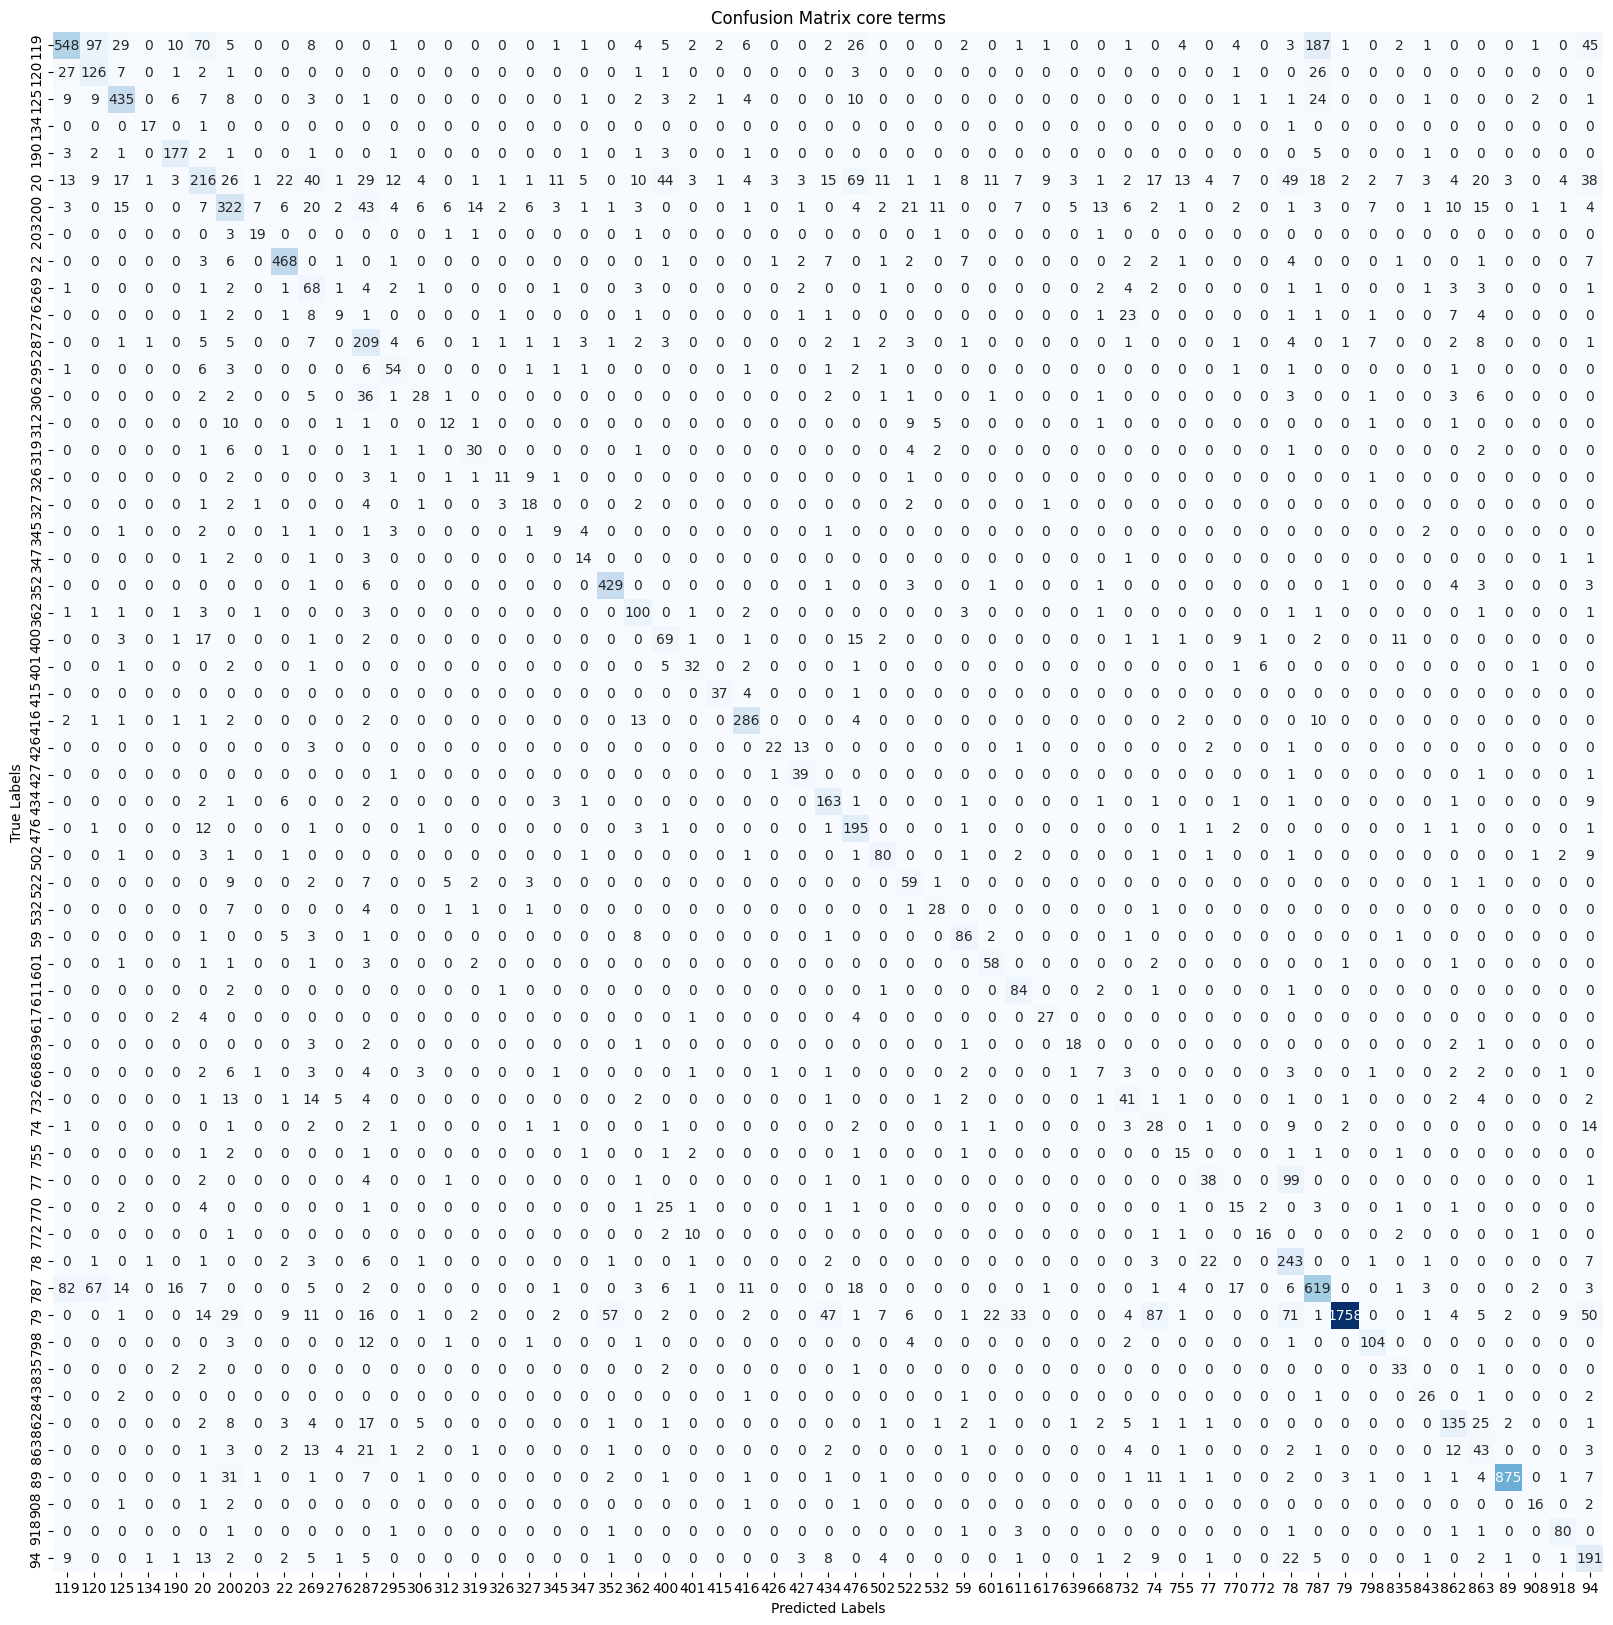

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report

# Assuming you have already generated the classification report
report = classification_report(y_test, y_pred_original, digits=4)

# Split the report by newline character
report_lines = report.split('\n')

# Extract labels from the second line onwards
labels = []
for line in report_lines[2:-3]:
    parts = line.split()
    if len(parts) > 0:
        labels.append(parts[0])

print(labels)
labels.pop(-1)
# Generate classification report
report = classification_report(y_test, y_pred_original, digits=4)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_original)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix core terms")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Mesurements

In [4]:
import joblib# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc/X_test.joblib')
y_test = joblib.load('reproduc/y_test.joblib')
unbalanced = joblib.load('reproduc/unbalanced.joblib')
y_pred_original = joblib.load('reproduc/y_pred_original.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 68 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

Total Sentences Below Short Threshold: 1514
Misclassified Short Sentences: 387
Percentage of Misclassified Short Sentences: 25.561426684280054
Total Sentences Above Long Threshold: 1238
Misclassified Long Sentences: 551
Percentage of Misclassified Long Sentences: 44.507269789983845


In [6]:
# Initialize counters for misclassified sentences
import joblib
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)


Total Sentences: 12845
Misclassified Sentences: 3960
Percentage of Misclassified Sentences: 30.829116387699496


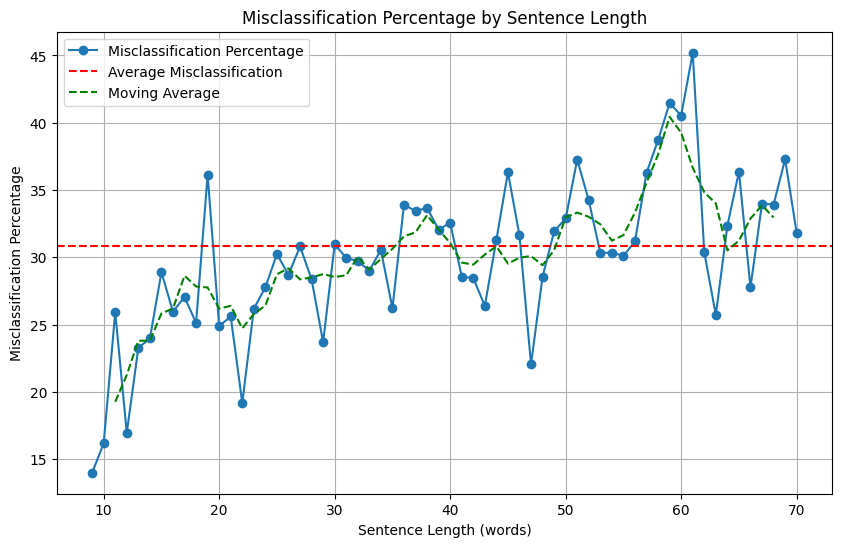

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 70 or description_words < 9:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

CWE classes training with core terms

In [31]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_core_terms_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_core_ada_embedding'] for item in balanced if item['cwe_class'] != 'None'])
test = np.array([item['cwe_class'] for item in balanced if item['cwe_class'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe_class'] != 'None'])
y_test = np.array([item['cwe_class'] for item in unbalanced if item['cwe_class'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_class.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_class.joblib')

In [10]:
# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc2/X_test.joblib')
y_test = joblib.load('reproduc2/y_test.joblib')
y_pred_original = joblib.load('reproduc2/y_pred_original.joblib')
unbalanced = joblib.load('reproduc2/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)


Total Sentences Below Short Threshold: 1430
Misclassified Short Sentences: 289
Percentage of Misclassified Short Sentences: 20.20979020979021
Total Sentences Above Long Threshold: 1412
Misclassified Long Sentences: 277
Percentage of Misclassified Long Sentences: 19.61756373937677


In [11]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)


Total Sentences: 12845
Misclassified Sentences: 2537
Percentage of Misclassified Sentences: 19.750875827170105


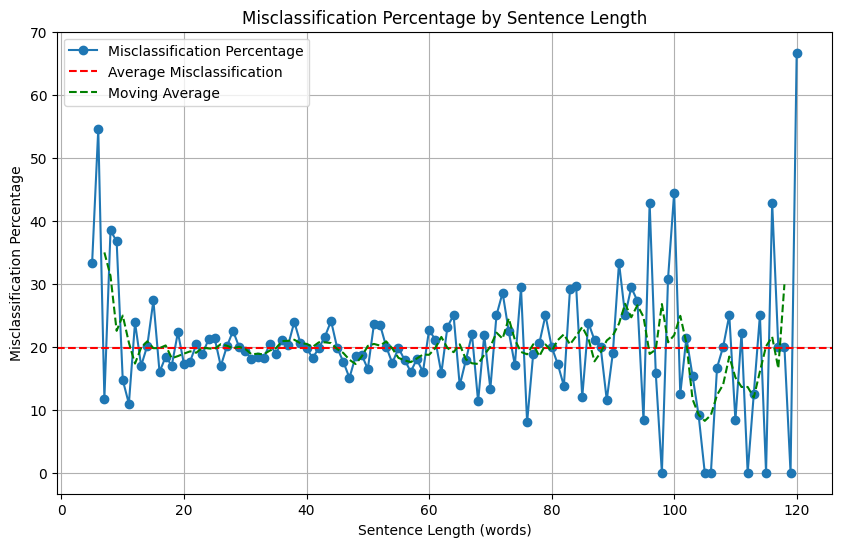

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 120:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4_high_abstr.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_core_terms_with_embeddings_high_abstr.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_core_ada_embedding'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
test = np.array([item['cwe_high_abstraction'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])
y_test = np.array([item['cwe_high_abstraction'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_abs.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_abs.joblib')

Epoch 1/40
225/225 [==============================] - 1s 2ms/step loss: 0.7834 -
Epoch 1 - F1 Score: 0.8078
Saved best model
[0.8077569494340507]
2025/2025 [==============================] - 11s 5ms/step - loss: 0.7834 - accuracy: 0.7500 - val_loss: 0.6126 - val_accuracy: 0.8078
Epoch 2/40
225/225 [==============================] - 1s 3ms/step loss: 0
Epoch 2 - F1 Score: 0.8208
Saved best model
[0.8077569494340507, 0.8207815857685845]
2025/2025 [==============================] - 10s 5ms/step - loss: 0.5938 - accuracy: 0.8136 - val_loss: 0.5728 - val_accuracy: 0.8196
Epoch 3/40
2025/2025 [==============================] - 9s 4ms/step - loss: 0.5665 - accuracy: 0.8210 - val_loss: 0.5750 - val_accuracy: 0.8166
Epoch 4/40
225/225 [==============================] - 1s 2ms/step loss: 0.545
Epoch 4 - F1 Score: 0.8277
Saved best model
[0.8077569494340507, 0.8207815857685845, 0.8190267084868317, 0.8277219990630932]
2025/2025 [==============================] - 9s 5ms/step - loss: 0.5452 - accura

['label_encoder_train_abs.joblib']

In [25]:
joblib.dump(X_test, 'reproduc3/X_test.joblib')
joblib.dump(y_test, 'reproduc3/y_test.joblib')
joblib.dump(y_pred_original, 'reproduc3/y_pred_original.joblib')
joblib.dump(unbalanced, 'reproduc3/unbalanced.joblib')

['reproduc3/unbalanced.joblib']

In [15]:
import joblib
# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc3/X_test.joblib')
y_test = joblib.load('reproduc3/y_test.joblib')
y_pred_original = joblib.load('reproduc3/y_pred_original.joblib')
unbalanced = joblib.load('reproduc3/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)


Total Sentences Below Short Threshold: 1429
Misclassified Short Sentences: 287
Percentage of Misclassified Short Sentences: 20.083974807557734
Total Sentences Above Long Threshold: 1405
Misclassified Long Sentences: 255
Percentage of Misclassified Long Sentences: 18.14946619217082
Average words per sentence: 40.6145443196005


In [16]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)

Total Sentences: 12817
Misclassified Sentences: 2545
Percentage of Misclassified Sentences: 19.856440664742138


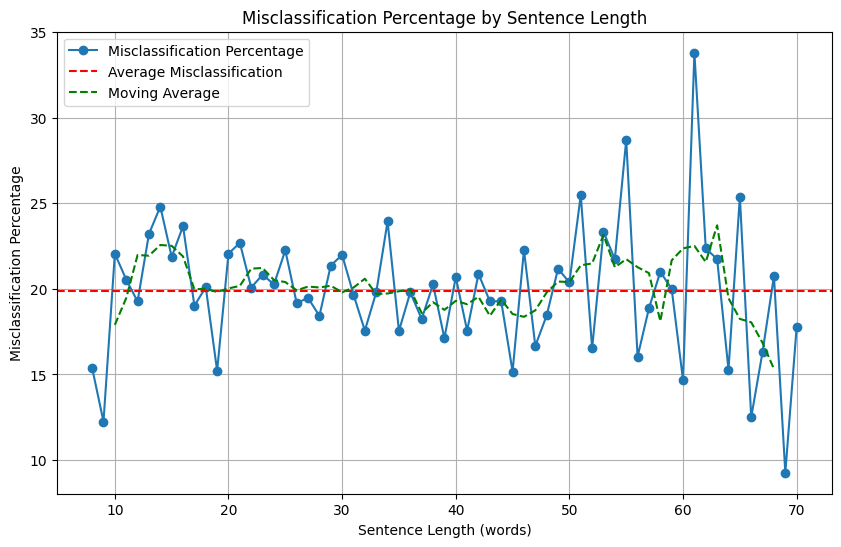

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 70 or description_words <8:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
misclassified_by_length = {}
total_by_length = {}

for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 70 words or less than 8 words
    if description_words > 70 or description_words < 8:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words].append((description, actual_label, predicted_label))
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = [(description, actual_label, predicted_label)] if actual_label != predicted_label else []
        total_by_length[description_words] = 1

# Print the misclassified label distribution based on word's length
for length, misclassified_samples in misclassified_by_length.items():
    total_count = total_by_length[length]
    print(f"Misclassified Samples with Description Length {length} Words:")
    for description, actual_label, predicted_label in misclassified_samples:
        print(f"Description: {description}")
        print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
        print()
    print(f"Total Misclassified Samples: {len(misclassified_samples)}, Total Samples: {total_count}, Misclassification Rate: {len(misclassified_samples) / total_count:.2f}\n")


Misclassified Samples with Description Length 67 Words:
Description: Redmine before 1.3.2 does not properly restrict the use of a hash to provide values for a model's attributes, which allows remote attackers to set attributes in the (1) Comment, (2) Document, (3) IssueCategory, (4) MembersController, (5) Message, (6) News, (7) TimeEntry, (8) Version, (9) Wiki, (10) UserPreference, or (11) Board model via a modified URL, related to a "mass assignment" vulnerability, a different vulnerability than CVE-2012-0327.
Actual Label: 255, Predicted Label: 264

Description: Microsoft Edge in Microsoft Windows 10 1511, 1607, 1703, and Windows Server 2016 allows an attacker to execute arbitrary code in the context of the current user, due to the way that the scripting engine handles objects in memory in Microsoft Edge, aka "Scripting Engine Memory Corruption Vulnerability". This CVE ID is unique from CVE-2017-8649, CVE-2017-8649, CVE-2017-8660, CVE-2017-8729, CVE-2017-8738, CVE-2017-8740, CVE-2017

In [27]:
word_length_distribution = {}

for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 80:
        continue

    # Update word length distribution
    if description_words in word_length_distribution:
        word_length_distribution[description_words] += 1
    else:
        word_length_distribution[description_words] = 1

# Print word length distribution
print("Word Length Distribution:")
for length, count in sorted(word_length_distribution.items()):
    print(f"Length {length}: {count} descriptions")


A potential use-after-free vulnerability existed in SVG Images if the Refresh Driver was destroyed at an inopportune time.  This could have lead to memory corruption or a potentially exploitable crash.
*Note*: This advisory was added on December 13th, 2022 after discovering it was inadvertently left out of the original advisory. The fix was included in the original release of Firefox 106. This vulnerability affects Firefox < 106.
['Use-after-Free Vulnerability', 'Memory Corruption', 'Exploitable Crash']
Adobe Substance 3D Painter versions 8.3.0 (and earlier) is affected by an out-of-bounds read vulnerability when parsing a crafted file, which could result in a read past the end of an allocated memory structure. An attacker could leverage this vulnerability to execute code in the context of the current user. Exploitation of this issue requires user interaction in that a victim must open a malicious file.
['Out-of-Bounds Read Vulnerability', 'Crafted File Parsing', 'Code Execution']
Redm

Distribution of CVE word's length

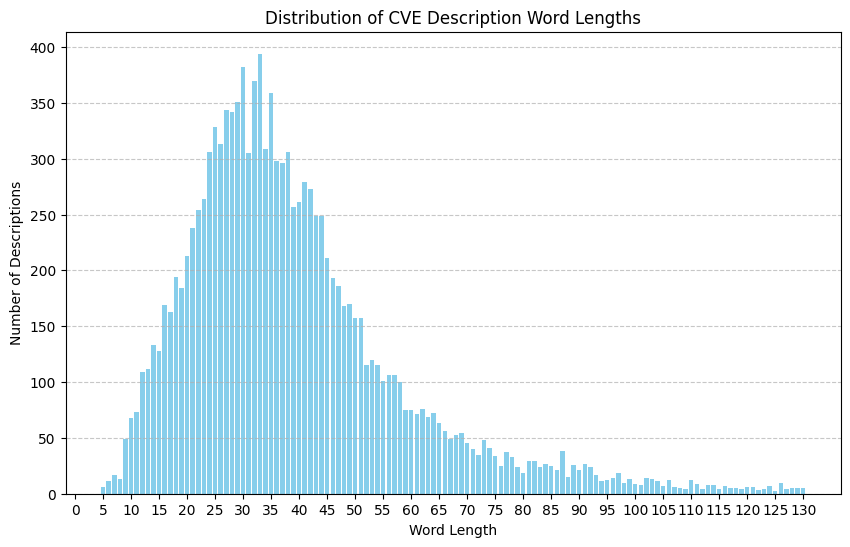

In [22]:
import matplotlib.pyplot as plt

# Convert word length distribution dictionary to lists for plotting
lengths, counts = zip(*sorted(word_length_distribution.items()))

# Plot word length distribution
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts, color='skyblue')
plt.xlabel('Word Length')
plt.ylabel('Number of Descriptions')
plt.title('Distribution of CVE Description Word Lengths')
plt.xticks(range(0, max(lengths)+1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
